In [1]:
# pip install matplotlib seaborn scikit-learn

Step 1: Import Necessary Libraries

In [1]:
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
# from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
class CustomLogoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for label, subdir in enumerate(['Fake', 'Genuine']):
            folder_path = os.path.join(self.root_dir, subdir)
            for filename in os.listdir(folder_path):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    self.images.append(os.path.join(folder_path, filename))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images) 

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [4]:
def load_trained_model(model_path):
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 2)  # Adjust for your number of classes
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model


In [5]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Adjust the path as necessary
test_dataset = CustomLogoDataset('FakeReal Logo Detection dataset/test', transform=image_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
def evaluate_model(model, dataloader):
    y_pred = []
    y_true = []
    y_scores = []  # Store the softmax probabilities

    model = model.to(torch.device('cpu'))  # or 'cuda' if using GPU
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.view(-1).tolist())
            y_true.extend(labels.view(-1).tolist())
            y_scores.extend(outputs.softmax(dim=1).tolist())  # Get softmax probabilities

    print(classification_report(y_true, y_pred, target_names=['Fake', 'Genuine']))

    return y_true, y_pred, y_scores


In [7]:
def plot_confusion_matrix(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Genuine'], yticklabels=['Fake', 'Genuine'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [8]:
import scikitplot as skplt
from sklearn.metrics import precision_recall_curve, roc_curve, auc


In [9]:
# def plot_precision_recall_curve(y_true, y_scores):
#     y_scores = np.array(y_scores)  # Convert to numpy array if not already
    
#     if y_scores.shape[1] > 1:  # If y_scores contains probabilities for multiple classes
#         precision, recall, _ = precision_recall_curve(y_true, y_scores[:, 1])
#     else:  # If y_scores contains probabilities for only one class
#         precision, recall, _ = precision_recall_curve(y_true, y_scores)
    
#     plt.step(recall, precision, color='b', alpha=0.2, where='post')
#     plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title('Precision-Recall curve')
#     plt.show()


In [10]:
# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend()
    plt.show()

In [11]:
def plot_roc_curve(y_true, y_scores):
    y_scores = np.array(y_scores)  # Convert to numpy array if not already
    
    if y_scores.shape[1] > 1:  # If y_scores contains probabilities for multiple classes
        fpr, tpr, _ = roc_curve(y_true, y_scores[:, 1])
    else:  # If y_scores contains probabilities for only one class
        fpr, tpr, _ = roc_curve(y_true, y_scores)
    
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


In [12]:
def plot_class_prediction_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate prediction errors
    errors = np.where(y_true != y_pred, 1, 0)

    # Calculate error rate for each class
    error_rates = []
    classes = np.unique(y_true)
    for class_label in classes:
        class_errors = errors[y_true == class_label]
        error_rate = np.mean(class_errors)
        error_rates.append(error_rate)

    # Plot the class prediction error
    plt.figure(figsize=(8, 6))
    plt.bar(classes, error_rates, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Error Rate')
    plt.title('Class Prediction Error')
    plt.xticks(classes)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


d:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00       110
     Genuine       0.98      1.00      0.99        55

    accuracy                           0.99       165
   macro avg       0.99      1.00      0.99       165
weighted avg       0.99      0.99      0.99       165



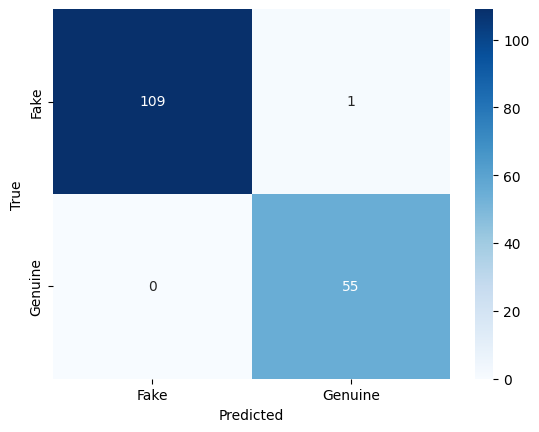

ValueError: y should be a 1d array, got an array of shape (165, 2) instead.

In [13]:
# Set the path to your model
model_path = 'fake_real_logo_detection_model.pth'
model = load_trained_model(model_path)

# Evaluate the model
y_true, y_pred, y_scores = evaluate_model(model, test_dataloader)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)

# Plot the precision-recall curve
plot_precision_recall_curve(y_true, y_scores)

# Plot the ROC curve
plot_roc_curve(y_true, y_scores)

# Plot the class prediction error
plot_class_prediction_error(y_true, y_pred)
